# ESMRMB 2025: Interactive Brain Visualizations

**Goal:** learn quick, reproducible ways to make interactive brain visualizations in Python (works in Google Colab).

**What you'll do**
1. Install tools and fetch example data
2. Make an interactive 3D cortical surface map with Plotly
3. Explore a statistical map with an interactive slice viewer
4. Build a tiny 3D connectome in Plotly
5. Upload & visualize your own NIfTI

> Tip: Run each cell in order. If you're in **Colab**, make sure the first cell (installs) finishes before moving on.


In [16]:
# --- Setup: installs (Colab-friendly) ---
! pip -q install nilearn nibabel plotly
import numpy as np
import nibabel as nib
import plotly.graph_objects as go
from nilearn import datasets, image, plotting, surface
from nilearn.datasets import fetch_surf_fsaverage, load_sample_motor_activation_image
print('Versions:')
import nilearn, sys
print('Python', sys.version)
print('nilearn', nilearn.__version__)
print('nibabel', nib.__version__)
import plotly
print('plotly', plotly.__version__)

Versions:
Python 3.12.11 (main, Jun  4 2025, 08:56:18) [GCC 11.4.0]
nilearn 0.12.1
nibabel 5.3.2
plotly 5.24.1


## 1) Get example data
We will fetch:
- **fsaverage** surfaces for plotting the cortex
- A sample **motor-task** statistical map from NeuroVault

In [19]:
fsavg = fetch_surf_fsaverage()
motor = load_sample_motor_activation_image()
stat_img = nib.load(motor)
stat_img

## 2) Interactive 3D cortical surface map (Plotly)
Pipeline:
1. Project the volume to the **cortical surface** (left hemisphere)
2. Create a Plotly triangular mesh (`Mesh3d`) for an interactive brain
3. Color vertices by the projected statistical values

> You can rotate, pan, and zoom.

In [20]:
# Project the statistical image to the left hemisphere surface
texture = surface.vol_to_surf(stat_img, fsavg.pial_left)

# Load left hemisphere geometry
coords, faces = surface.load_surf_mesh(fsavg.pial_left)
x, y, z = coords.T
i, j, k = faces.T

# Normalize texture for coloring (keep raw & normalized for hover)
vals = (texture - np.nanmin(texture)) / (np.nanmax(texture) - np.nanmin(texture) + 1e-6)

# customdata with two columns: [raw, normalized]
import numpy as _np
_customdata = _np.column_stack([texture, vals])

fig = go.Figure(data=[go.Mesh3d(
    x=x, y=y, z=z,
    i=i, j=j, k=k,
    intensity=vals,
    customdata=_customdata,
    hovertemplate=(
        "x=%{x:.2f}<br>"
        "y=%{y:.2f}<br>"
        "z=%{z:.2f}<br>"
        "stat_raw=%{customdata[0]:.3f}<br>"
        "stat_norm=%{customdata[1]:.3f}"
        "<extra></extra>"
    ),
    colorscale='Viridis',
    showscale=True, opacity=1.0
)])
fig.update_layout(title='Interactive Cortical Surface (LH)',
                  scene=dict(xaxis=dict(visible=False),
                             yaxis=dict(visible=False),
                             zaxis=dict(visible=False)),
                  width=800, height=500)
fig.show()

In [23]:
# Project the statistical image to the right hemisphere surface
texture = surface.vol_to_surf(stat_img, fsavg.pial_right)

# Load right hemisphere geometry
coords, faces = surface.load_surf_mesh(fsavg.pial_right)
x, y, z = coords.T
i, j, k = faces.T

# Normalize texture for coloring (keep raw & normalized for hover)
vals = (texture - np.nanmin(texture)) / (np.nanmax(texture) - np.nanmin(texture) + 1e-6)

# customdata with two columns: [raw, normalized]
import numpy as _np
_customdata = _np.column_stack([texture, vals])

fig = go.Figure(data=[go.Mesh3d(
    x=x, y=y, z=z,
    i=i, j=j, k=k,
    intensity=vals,
    customdata=_customdata,
    hovertemplate=(
        "x=%{x:.2f}<br>"
        "y=%{y:.2f}<br>"
        "z=%{z:.2f}<br>"
        "stat_raw=%{customdata[0]:.3f}<br>"
        "stat_norm=%{customdata[1]:.3f}"
        "<extra></extra>"
    ),
    colorscale='Viridis',
    showscale=True, opacity=1.0
)])
fig.update_layout(title='Interactive Cortical Surface (RH)',
                  scene=dict(xaxis=dict(visible=False),
                             yaxis=dict(visible=False),
                             zaxis=dict(visible=False)),
                  width=800, height=500)
fig.show()

## 3) Interactive slice viewer (`nilearn.plotting.view_img`)
This widget lets you adjust **threshold, colormap, and opacity** interactively in the notebook.

/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:820: UserWarning:





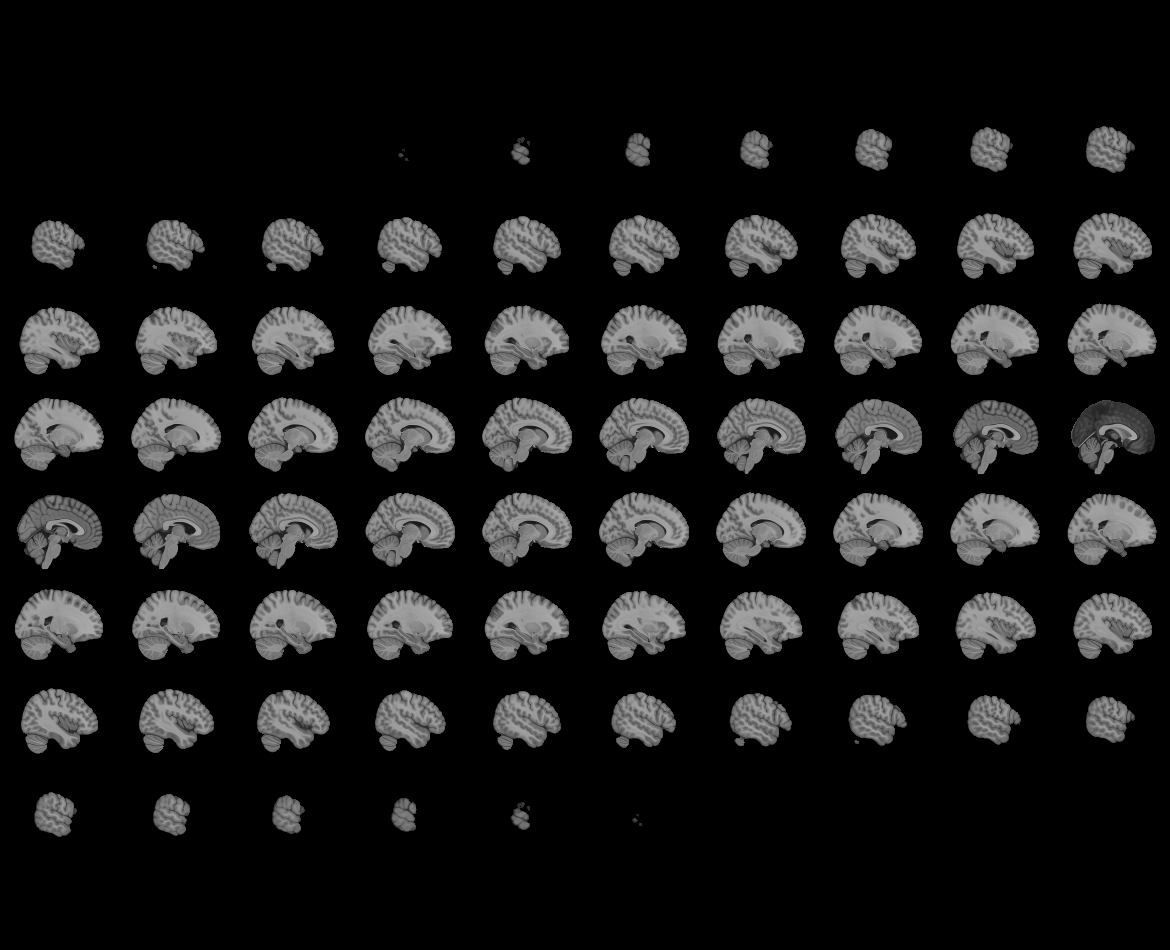
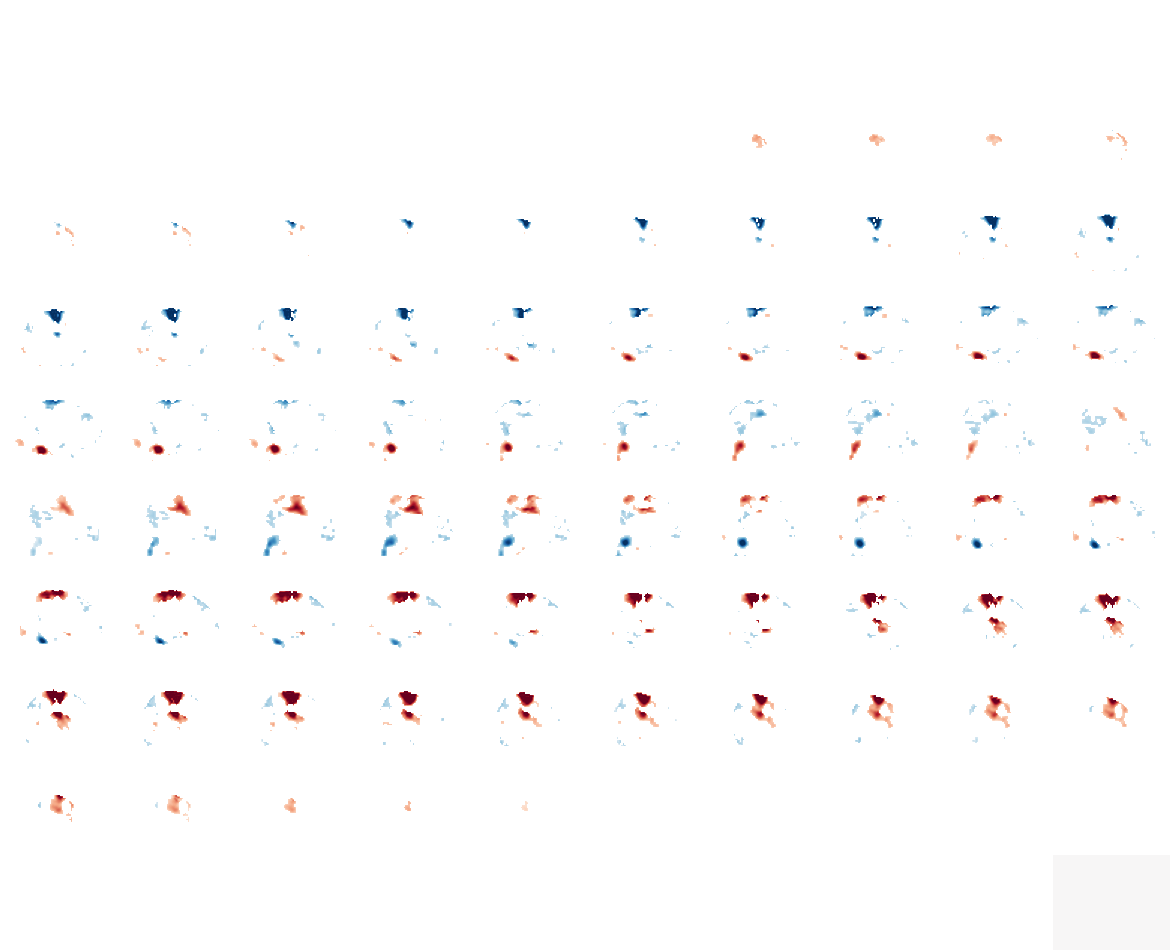

In [21]:
view = plotting.view_img(stat_img, threshold='95%', symmetric_cmap=False)
view

## 4) Tiny 3D connectome in Plotly
We’ll create a small set of nodes and weighted edges and draw them in 3D with interactivity.

In [14]:
np.random.seed(0)
n_nodes = 10
nodes = np.random.uniform(-50, 50, size=(n_nodes, 3))
A = np.random.rand(n_nodes, n_nodes)
A = (A + A.T)/2
A[A < 0.8] = 0  # sparsify

edge_x, edge_y, edge_z = [], [], []
for a in range(n_nodes):
    for b in range(a+1, n_nodes):
        if A[a, b] > 0:
            x0, y0, z0 = nodes[a]
            x1, y1, z1 = nodes[b]
            edge_x += [x0, x1, None]
            edge_y += [y0, y1, None]
            edge_z += [z0, z1, None]

node_trace = go.Scatter3d(x=nodes[:,0], y=nodes[:,1], z=nodes[:,2],
                          mode='markers', marker=dict(size=6), name='Nodes')
edge_trace = go.Scatter3d(x=edge_x, y=edge_y, z=edge_z, mode='lines', name='Edges')

fig = go.Figure(data=[edge_trace, node_trace])
fig.update_layout(title='Mini 3D Connectome (toy)',
                  scene=dict(xaxis=dict(visible=False),
                             yaxis=dict(visible=False),
                             zaxis=dict(visible=False)),
                  showlegend=False, width=800, height=500)
fig.show()

### 5) Upload & visualize your own NIfTI
In Colab, run the next cell and choose a `.nii` or `.nii.gz` file. Then view it interactively.

In [ ]:
try:
    from google.colab import files
    uploaded = files.upload()
    upname = list(uploaded.keys())[0]
    img = nib.load(upname)
    plotting.view_img(img, threshold=None)
except Exception as e:
    print('Upload available only in Google Colab. If local, provide a path to your NIfTI and use nibabel to load it.')
    print(e)

## 6) Exercises (pick 1–2)
- Change the hemisphere to **right** and re‑plot the surface.
- Swap the statistical image for another from the NeuroVault motor set.
- Adjust volume rendering parameters (`opacity`, `surface_count`).
- Add **hover text** to nodes in the connectome plot.
- Upload your own map and try different thresholds in `view_img`.

### Bonus: Save figures
```python
fig.write_html('figure.html', include_plotlyjs='cdn')
```


---
If something breaks in Colab due to versions, re‑run the **setup** cell and then `Runtime → Restart runtime`.